Автор: Лейман М.А.  
Дата создания: 14.06.2025 

# Итоговая аттестация 
### __проект 7:__   _Семантическая сегментация с помощью U-Net на уличных сценах_  



## Задание  
-​ Реализация U-Net или DeepLabv3 для пиксельной классификации дорожных сцен (дорог, пешеходов, транспортных средств и пр)  

-​ Оценка, например, на Cityscapes или Pascal VOC.  

-​ Визуализация масок сегментаций, наложенных на исходные  изображения, с помощью OpenCV  


## Импорты 

In [ ]:
from attestation import CityscapesFlatDataset, CityscapesFlatDataset2, merge_folders, train_model,\
                        prepare_cityscapes_loaders, visualize_segmentation, emty_cache, visualize_image_and_mask, prediction_mask


import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"
os.environ['CUDA_LAUNCH_BLOCKING'] = '1' 
import warnings
import copy
import torch.optim as optim
import time
import numpy as np
import torch
from torch.utils.data import random_split, DataLoader
from torchsummary import summary
from tqdm import tqdm
from torch.optim import lr_scheduler
from matplotlib import rcParams
import shutil
from PIL import Image
from torch.utils.data import Dataset
import cv2
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
import gc

warnings.filterwarnings("ignore")
np.random.seed(42)
#set_global_seed(42)
rcParams['figure.figsize'] = (14,6)

## Параметры

In [2]:
# Классы
CITYSCAPES_PALETTE = np.array([
    [0, 0, 0],      # ФОН
    [128, 64,128],  # road
    [244, 35,232],  # sidewalk
    [70, 70, 70],   # building
    [102,102,156],  # wall
    [190,153,153],  # fence
    [153,153,153],  # pole
    [250,170, 30],  # traffic light
    [220,220,  0],  # traffic sign
    [107,142, 35],  # vegetation
    [152,251,152],  # terrain
    [70,130,180],   # sky
    [220, 20, 60],  # person
    [255,  0,  0],  # rider
    [0,  0,142],    # car
    [0,  0, 70],    # truck
    [0, 60,100],    # bus
    [0, 80,100],    # train
    [0,  0,230],    # motorcycle
    [119, 11, 32],  # bicycle
])


In [3]:
# устанавливаем device если gpu или cpu


if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("работаем на устройстве: ", device)
print('Версия torch:           ', torch.__version__)
print("версия  cuDNN:          ", torch.backends.cudnn.version())

# ПРОВЕРКА GPU
!nvidia-smi

работаем на устройстве:  cuda
Версия torch:            2.6.0+cu124
версия  cuDNN:           90100
Tue Jun 17 18:27:01 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.03             Driver Version: 550.144.03     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060        Off |   00000000:01:00.0  On |                  N/A |
| 30%   46C    P2             59W /  170W |    9143MiB /  12288MiB |     20%      Default |
|                                         

## Загрузка данных 

### Датасет

In [4]:
# Путь к папкам с исходными данными
images_root = './dataset/images'
targets_root = './dataset/targets'

# Папки для объединённых данных
images_merged = './dataset/images_merged'
targets_merged = './dataset/targets_merged'

# merge_folders(images_root, images_merged)
# merge_folders(targets_root, targets_merged)


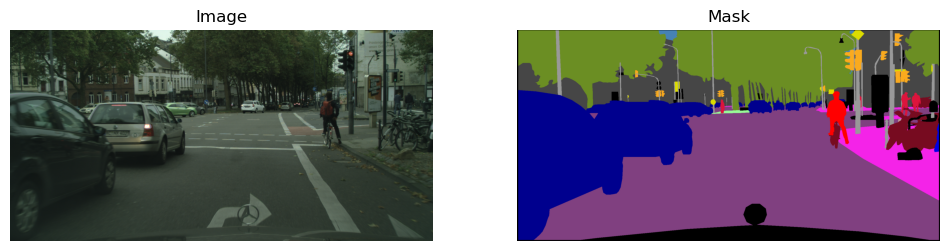

In [5]:
root_dir = './dataset'
dataset = CityscapesFlatDataset(root_dir)
# Использование с вашим датасетом
image, mask = dataset[10]
visualize_image_and_mask(image, mask, class_palette=CITYSCAPES_PALETTE)

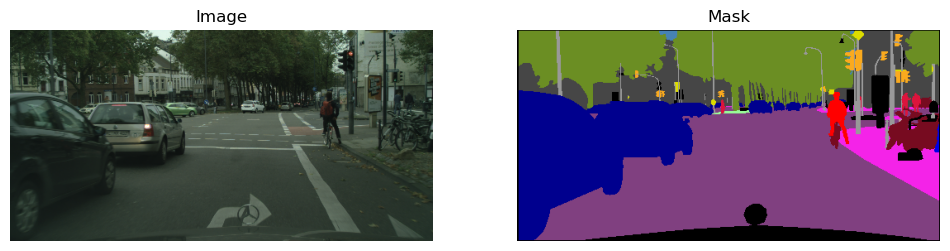

In [6]:
root_dir = './dataset'
dataset = CityscapesFlatDataset2(root_dir)
# Использование с вашим датасетом
image, mask = dataset[10]

visualize_image_and_mask(image, mask, class_palette=CITYSCAPES_PALETTE)

In [7]:
print(np.unique(mask))


[ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 18 19]


### Разделение датасета

In [8]:
batch_size = 16
size = 256, 512

train_loader, val_loader, train_dataset, val_dataset = prepare_cityscapes_loaders(
            CityscapesFlatDataset2, './dataset', size, batch_size=batch_size
        )

# Размеры тензоров
for images, masks in train_loader:
    print(images.shape)  # [batch_size, 3, H, W]
    print(masks.shape)   # [batch_size, 1, H, W]
    masks = masks.squeeze(1)  # [batch_size, H, W]
    break



Train size: 2780, Validation size: 695
torch.Size([16, 3, 256, 512])
torch.Size([16, 256, 512])


## Модели

### 3) __UnetPlusPlus__  

In [9]:
import segmentation_models_pytorch as smp

# Параметры модели
ENCODER = "resnet34"           # энкодер (backbone)
ENCODER_WEIGHTS = "imagenet"   # предобученные веса энкодера
CLASSES = 20                   # количество классов сегментации
ACTIVATION = None              # активация на выходе (например, 'softmax' или None)

# Создаём модель UNet++
model_unetpp = smp.UnetPlusPlus(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=CLASSES,
    activation=ACTIVATION,
)


## Обучение

### 3) __UnetPlusPlus__  

Epoch 1 Val: 100%|██████████| 44/44 [00:54<00:00,  1.24s/it, acc=0.918, iou=0.467, loss=0.292]


Epoch 1 summary: Train Loss: 0.4124, Acc: 0.8749, IoU: 0.4473 | Val Loss: 0.2611, Acc: 0.9193, IoU: 0.5057
Сохранена лучшая модель 1 с val IoU: 0.5057


Epoch 2 Val: 100%|██████████| 44/44 [00:56<00:00,  1.28s/it, acc=0.912, iou=0.417, loss=0.385]


Epoch 2 summary: Train Loss: 0.3878, Acc: 0.8817, IoU: 0.4634 | Val Loss: 0.2879, Acc: 0.9145, IoU: 0.4778


Epoch 3 Val: 100%|██████████| 44/44 [00:56<00:00,  1.28s/it, acc=0.917, iou=0.45, loss=0.32]  


Epoch 3 summary: Train Loss: 0.3536, Acc: 0.8893, IoU: 0.4785 | Val Loss: 0.2684, Acc: 0.9193, IoU: 0.5098
Сохранена лучшая модель 3 с val IoU: 0.5098


Epoch 4 Val: 100%|██████████| 44/44 [00:56<00:00,  1.28s/it, acc=0.901, iou=0.448, loss=0.346]


Epoch 4 summary: Train Loss: 0.3345, Acc: 0.8955, IoU: 0.4932 | Val Loss: 0.3388, Acc: 0.9019, IoU: 0.4798


Epoch 5 Val: 100%|██████████| 44/44 [00:56<00:00,  1.27s/it, acc=0.918, iou=0.426, loss=0.359]


Epoch 5 summary: Train Loss: 0.3254, Acc: 0.8976, IoU: 0.4983 | Val Loss: 0.2660, Acc: 0.9179, IoU: 0.5016


Epoch 6 Val: 100%|██████████| 44/44 [00:56<00:00,  1.28s/it, acc=0.929, iou=0.472, loss=0.297]


Epoch 6 summary: Train Loss: 0.2803, Acc: 0.9091, IoU: 0.5330 | Val Loss: 0.2229, Acc: 0.9310, IoU: 0.5428
Сохранена лучшая модель 6 с val IoU: 0.5428


Epoch 7 Val: 100%|██████████| 44/44 [00:57<00:00,  1.30s/it, acc=0.93, iou=0.474, loss=0.301] 


Epoch 7 summary: Train Loss: 0.2568, Acc: 0.9190, IoU: 0.5569 | Val Loss: 0.2208, Acc: 0.9315, IoU: 0.5463
Сохранена лучшая модель 7 с val IoU: 0.5463


Epoch 8 Val: 100%|██████████| 44/44 [00:56<00:00,  1.29s/it, acc=0.932, iou=0.475, loss=0.282]


Epoch 8 summary: Train Loss: 0.2482, Acc: 0.9212, IoU: 0.5601 | Val Loss: 0.2147, Acc: 0.9338, IoU: 0.5496
Сохранена лучшая модель 8 с val IoU: 0.5496


Epoch 9 Val: 100%|██████████| 44/44 [00:56<00:00,  1.29s/it, acc=0.933, iou=0.483, loss=0.278]


Epoch 9 summary: Train Loss: 0.2392, Acc: 0.9250, IoU: 0.5708 | Val Loss: 0.2117, Acc: 0.9351, IoU: 0.5513
Сохранена лучшая модель 9 с val IoU: 0.5513


Epoch 10 Val: 100%|██████████| 44/44 [00:56<00:00,  1.29s/it, acc=0.933, iou=0.487, loss=0.275]


Epoch 10 summary: Train Loss: 0.2355, Acc: 0.9258, IoU: 0.5757 | Val Loss: 0.2134, Acc: 0.9343, IoU: 0.5501


Epoch 11 Val: 100%|██████████| 44/44 [00:56<00:00,  1.29s/it, acc=0.934, iou=0.486, loss=0.273]


Epoch 11 summary: Train Loss: 0.2212, Acc: 0.9300, IoU: 0.5897 | Val Loss: 0.2091, Acc: 0.9351, IoU: 0.5543
Сохранена лучшая модель 11 с val IoU: 0.5543


Epoch 12 Val: 100%|██████████| 44/44 [00:56<00:00,  1.28s/it, acc=0.934, iou=0.485, loss=0.271]


Epoch 12 summary: Train Loss: 0.2178, Acc: 0.9292, IoU: 0.5931 | Val Loss: 0.2091, Acc: 0.9358, IoU: 0.5563
Сохранена лучшая модель 12 с val IoU: 0.5563


Epoch 13 Val: 100%|██████████| 44/44 [00:56<00:00,  1.28s/it, acc=0.934, iou=0.489, loss=0.27] 


Epoch 13 summary: Train Loss: 0.2159, Acc: 0.9311, IoU: 0.5936 | Val Loss: 0.2097, Acc: 0.9355, IoU: 0.5566
Сохранена лучшая модель 13 с val IoU: 0.5566


Epoch 14 Val: 100%|██████████| 44/44 [00:56<00:00,  1.28s/it, acc=0.934, iou=0.493, loss=0.266]


Epoch 14 summary: Train Loss: 0.2128, Acc: 0.9315, IoU: 0.5998 | Val Loss: 0.2081, Acc: 0.9359, IoU: 0.5588
Сохранена лучшая модель 14 с val IoU: 0.5588


Epoch 15 Val: 100%|██████████| 44/44 [00:55<00:00,  1.27s/it, acc=0.934, iou=0.489, loss=0.267]


Epoch 15 summary: Train Loss: 0.2111, Acc: 0.9311, IoU: 0.5998 | Val Loss: 0.2097, Acc: 0.9355, IoU: 0.5569


Epoch 16 Val: 100%|██████████| 44/44 [00:55<00:00,  1.27s/it, acc=0.935, iou=0.491, loss=0.27] 


Epoch 16 summary: Train Loss: 0.2053, Acc: 0.9337, IoU: 0.6070 | Val Loss: 0.2070, Acc: 0.9369, IoU: 0.5581


Epoch 17 Val: 100%|██████████| 44/44 [00:56<00:00,  1.27s/it, acc=0.935, iou=0.49, loss=0.265] 


Epoch 17 summary: Train Loss: 0.2061, Acc: 0.9327, IoU: 0.6073 | Val Loss: 0.2076, Acc: 0.9363, IoU: 0.5589
Сохранена лучшая модель 17 с val IoU: 0.5589


Epoch 18 Val: 100%|██████████| 44/44 [00:56<00:00,  1.28s/it, acc=0.935, iou=0.492, loss=0.265]


Epoch 18 summary: Train Loss: 0.2043, Acc: 0.9343, IoU: 0.6083 | Val Loss: 0.2078, Acc: 0.9362, IoU: 0.5589
Сохранена лучшая модель 18 с val IoU: 0.5589


Epoch 19 Val: 100%|██████████| 44/44 [00:56<00:00,  1.28s/it, acc=0.935, iou=0.491, loss=0.267]


Epoch 19 summary: Train Loss: 0.2054, Acc: 0.9334, IoU: 0.6059 | Val Loss: 0.2085, Acc: 0.9364, IoU: 0.5584


Epoch 20 Val: 100%|██████████| 44/44 [00:56<00:00,  1.27s/it, acc=0.935, iou=0.49, loss=0.268] 


Epoch 20 summary: Train Loss: 0.2029, Acc: 0.9344, IoU: 0.6097 | Val Loss: 0.2087, Acc: 0.9360, IoU: 0.5573


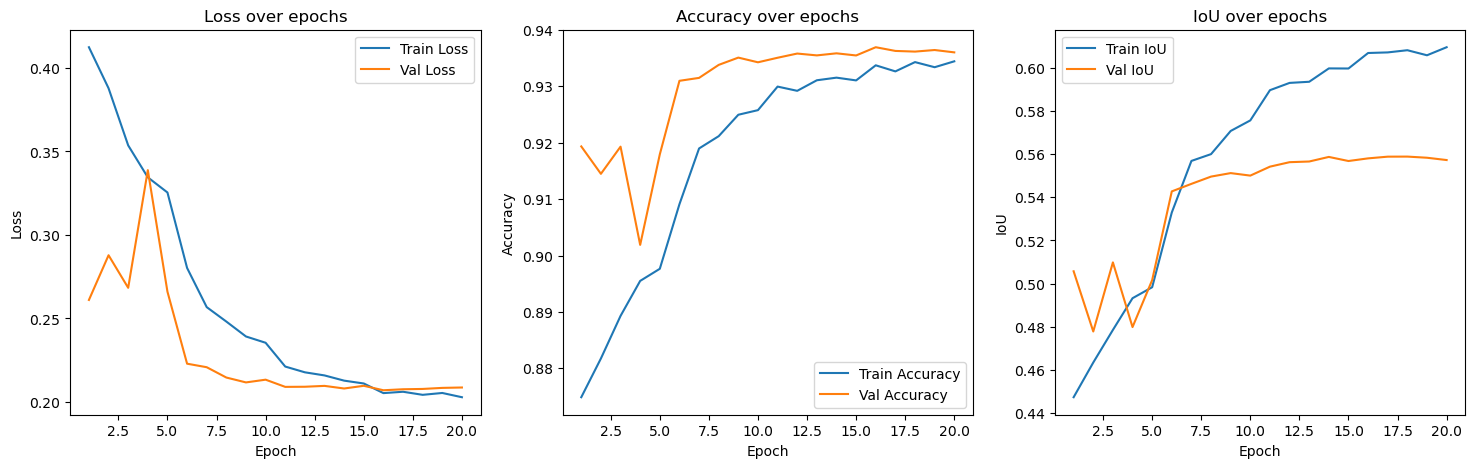

In [ ]:
emty_cache()

optimizer = torch.optim.Adam(model_unetpp.parameters(), lr=0.0003)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.3)

model_unetpp.load_state_dict(torch.load('models/unetpp_model2.pth', map_location=torch.device('cpu'))) 


train_model(model_unetpp, train_loader, val_loader, optimizer, device, num_epochs=20, scheduler=scheduler, save_path='models/unetpp_model2.pth')

In [13]:
print(torch.cuda.memory_summary())


|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      | 415379 KiB |   7894 MiB | 124713 GiB | 124712 GiB |
|       from large pool | 369408 KiB |   7849 MiB | 124615 GiB | 124614 GiB |
|       from small pool |  45971 KiB |     67 MiB |     98 GiB |     98 GiB |
|---------------------------------------------------------------------------|
| Active memory         | 415379 KiB |   7894 MiB | 124713 GiB | 124712 GiB |
|       from large pool | 369408 KiB |   7849 MiB | 124615 GiB |

## Использование модели

In [ ]:
model_unetpp.load_state_dict(torch.load('models/unetpp_model2.pth', map_location=torch.device(device))) 
model_unetpp.eval();
model_unetpp = model_unetpp.to(device)

from PIL import Image
from torchvision import transforms
path_img = './dataset/images2/train/hamburg/hamburg_000000_008494_leftImg8bit.png'

img = Image.open(path_img)
preprocess = transforms.Compose([
    transforms.Resize((256, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
img_tensor = preprocess(img).unsqueeze(0)  

with torch.no_grad():
    img_tensor = img_tensor.to(device) 
    output = model_unetpp(img_tensor)
    prediction = torch.argmax(output, dim=1)  

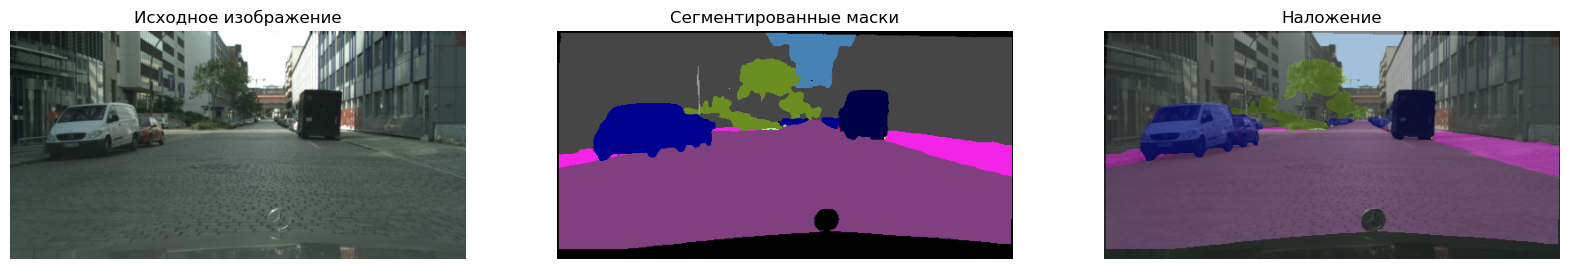

In [ ]:
img, prediction = prediction_mask(path_img, model_unetpp)
visualize_segmentation(img, prediction, CITYSCAPES_PALETTE)